# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 07.10.2023

Мягкий дедлайн: 23:59MSK 20.10.2023

Жесткий дедлайн: 23:59MSK 24.10.2023

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Итогова оценка считается как
$$
min(task_1, task_2)*0.6 + max(task_1, task_2)*0.2 + task_4*0.2
$$

где $task_1$, $task_2$ и $task_4$ - оценки за первое и второе заданиее соответсвенно.
Также, за домашнее задание выставляется 0, если не сделано нулевое или третье задание.
### О задании

В этом задании вам предстоит предсказывать год выпуска песни (**задача регрессии**) по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
device = "cuda" if torch.cuda.is_available() else "cpu"
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2024-10-24 20:20:13--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘data.txt.zip’

data.txt.zip            [               <=>  ] 201.24M  66.9MB/s    in 3.0s    

2024-10-24 20:20:16 (66.9 MB/s) - ‘data.txt.zip’ saved [211011981]



In [ ]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


Мы вывели кусок данных, чтобы понять, насколько они пригодны для работы без изменений. Здесь ясно, что сомнительно дальше с такими данными работать, потому что как минимум есть отрицательные значения, которые не отмасштабированы, кроме того еще сразу бросается в глаза совсем разная размерность, где-то видим реально большие числа, а где-то 0.075. Ясно, что будем скейлить.

In [ ]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

Для выполнения данного задания (и всех последующих) предобработайте данные.

1. Зафиксируйте random_seed везде где только возможно. Вам предоставлена функция для этого, однако вы можете дополнить ее своими дополнениями
2. Обучите StandertScaler и предобработайте ваши данные. В следующих заданиях можете использовать другой scaler или вообще отказаться от него


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [ ]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    # Add smth here if you need...

In [ ]:
set_random_seed(42)

In [ ]:
# Масштабируем вещественные признаки.
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import root_mean_squared_error

# Обучаем Ridge-регрессию.
model = Ridge(random_state=42).fit(X_train_norm, y_train)
# Считаем RMSE на тестовой выборке.
rmse_for_model = root_mean_squared_error(y_test, model.predict(X_test_norm))
print('Ridge regression:')
print(f'RMSE on test = {rmse_for_model}')

Ridge regression:
RMSE on test = 9.510160820470436


Лучшая константа для RMSE это среднее, посчитаем значение метрики при нем

In [ ]:
# Считаем RMSE по среднему значению на обучающей выборке.
best_rmse_metric = root_mean_squared_error(y_test, np.full(y_test.shape, y_train.mean()))
print(f'Best RMSE metric = {best_rmse_metric}')

Best RMSE metric = 10.85246390513634


## Задание 1. (максимум 10 баллов)

Закрепите свои знания о том, как pytorch работает с обратным распространением ошибки, проделав следующие шаги:

1. Создайте модель линейной регрессии, которая будет состоять только из одного Linear слоя.
2. Напишите цикл обучения вашей линейной регрессии. В нем реализуйте подсчет функции потерь, сделайте шаг градиентного спуска. Запрещено использовать готовые оптимизаторы и loss-функции из библиотеки pytorch. Для подсчета градиента воспользуйтесь методом backward.
3. Запустите обучение на 10 эпохах, после каждой проверяйте значение целевой метрики на тестовой выборке.
4. Выведите на экран графики метрики и значения функции потерь на тестовой и обучающей выборке.

В данном задании нет цели побить какой-то порог по метрике. Ваша задача - убедиться в том, что ваш рукописный цикл обучения работает. Для ускорения вычислений и обучения модели можете брать только срез данных, а не весь датасет.

In [ ]:
# Сразу сделаем все приготовления для создания нейросети здесь.
# Класс датасета.
class MusicDataset(torch.utils.data.Dataset):
    """Music dataset"""

    def __init__(self, x, y):
        self.x=x
        self.y=y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return torch.tensor(self.x[idx, :], dtype=torch.double), self.y[idx]

# Построение графиков метрики и значения функции потерь на тестовой и обучающей выборке.
sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})

def plot_losses(train_losses, test_losses):
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train')
    plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test')
    plt.ylabel('Loss (RMSE)')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

In [ ]:
# Класс нейросети из одного линейного слоя.
class LinearNet(nn.Module):
    def __init__(self, in_features, out_size):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features, out_size)
        )

    def forward(self, X):
       return self.model(X)

# Функция MSE.
def mse(y_true, y_pred):
    return torch.mean((y_true - y_pred)**2)

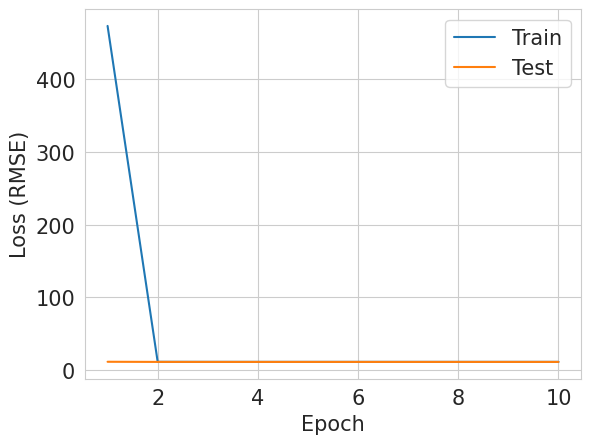

Train loss: 10.94
Test loss: 10.85


In [ ]:
set_random_seed(42)

train_dataset = MusicDataset(X_train_norm, y_train)
test_dataset = MusicDataset(X_test_norm, y_test)

# Делим выборки на батчи с помощью Dataloader.
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1024)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=5000)

# Количество эпох.
epochs = 10

# Параметры модели.
INPUTS = 90
OUTPUTS = 1

# Размер шага градиентного спуска.
eta = 0.01

# Модель линейной регрессии.
model = LinearNet(INPUTS, OUTPUTS).to(torch.double).to(device)

# Списки для хранения значений потерь (нужны для построения графиков).
train_losses, test_losses = [], []

# Циклы эпох.
for i in range(epochs):
    train_loss = 0.0
    model.train()
    for X, y in train_loader:
        X = X.to(device)
        y = y.to(device)

        model.zero_grad()
        # Вычисляем значение функции потерь на обучающей выборке.
        y_train_pred = model(X)
        loss = mse(y, y_train_pred)

        # Выполняем шаг градиентного спуска.
        loss.backward()
        with torch.no_grad():
            for param in model.parameters():
                param.data -= eta * param.grad.data
        train_loss += loss.item() * X.shape[0]

    train_loss /= len(train_loader.dataset)
    train_loss = train_loss**0.5
    train_losses.append(train_loss)

    # Вычисляем значение метрики на тестовой выборке.
    test_loss = 0.0
    model.eval()
    for X, y in test_loader:
        X = X.to(device)
        y = y.to(device)

        with torch.no_grad():
            y_test_pred = model(X)
            loss = mse(y, y_test_pred)
        test_loss += loss.item() * X.shape[0]

    test_loss /= len(test_loader.dataset)
    test_loss = test_loss**0.5
    test_losses.append(test_loss)

    # Строим графики.
    if (i % 2 == 1):
        clear_output()
        plot_losses(train_losses, test_losses)
        print("Train loss:", "{:.2f}".format(train_loss))
        print("Test loss:", "{:.2f}".format(test_loss))

## Задание 2. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Не забудьте, что для улучшения качества модели вам поможет **нормировка таргета**.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из предыдущего задания.



Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться сигнатурами функций, которые приведены ниже. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

In [ ]:
# Класс нейросети.
class BebraNet(nn.Module):
    def __init__(self, in_features, hidden_size, out_size, p=0.25):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(in_features, hidden_size),
            nn.ReLU(),
            #nn.Dropout(p),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            #nn.Dropout(p),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            #nn.Dropout(p),
            nn.Linear(hidden_size, out_size),
        )

    def forward(self, X):
       return self.model(X)

# Кастомный RMSE Loss (Видимо, плохой)
#class RMSELoss(nn.Module):
#    def __init__(self):
#        super(RMSELoss, self).__init__()
#        self.mse_loss = nn.MSELoss()
#
#    def forward(self, predictions, targets):
#        return torch.sqrt(self.mse_loss(predictions, targets))

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Нормируем признаки
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

# Подготавливаем скейлер для таргета
target_scaler = StandardScaler()
target_scaler.fit(y_train.reshape(-1, 1))
y_train_norm = target_scaler.transform(y_train.reshape(-1, 1))

INPUTS = 90
OUTPUTS = 1
HIDDEN_SIZE = 640
EPOCHS = 150

set_random_seed(42)

train_set = MusicDataset(X_train_norm, y_train_norm)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=1024, shuffle=True)

test_set = MusicDataset(X_test_norm, y_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=10000)

model = BebraNet(INPUTS, HIDDEN_SIZE, OUTPUTS).to(torch.double).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=25)
criterion = nn.MSELoss() # Используем MSE для функции потерь, при выводе результатов будем брать корень.

In [ ]:
def train(model, optimizer, criterion, train_loader, test_loader, scheduler=None):
    """
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        test_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
    """
    # Список для хранения значений потерь (нужны для построения графиков).
    train_losses, test_losses = [], []

    progress_bar = tqdm(range(1, EPOCHS + 1), desc='Training')

    # Цикл эпох обучения.
    for epoch in progress_bar:
        train_loss = 0.0

        model.train()
        for X, y in train_loader:
            X = X.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            logits = model(X)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
            with torch.no_grad(): # Добавил обратное преобразование лосса для графика train.
                loss = criterion(torch.from_numpy(target_scaler.inverse_transform(logits.reshape(-1,1).cpu()).flatten()), torch.from_numpy(target_scaler.inverse_transform(y.reshape(-1,1).cpu()).flatten()))
            train_loss += loss.item() * X.shape[0]

        train_loss = (train_loss / len(train_loader.dataset)) ** 0.5
        train_losses.append(train_loss)
        # Применяем scheduler, если юзаем его.
        if scheduler is not None:
            scheduler.step(train_loss)

        test_loss = 0.0
        model.eval()
        for X, y in test_loader:
            X = X.to(device)
            y = y

            with torch.no_grad():
                logits = model(X)
                loss = criterion(torch.from_numpy(target_scaler.inverse_transform(logits.reshape(-1,1).cpu()).flatten()), y)
            test_loss += loss.item() * X.shape[0]

        test_loss = (test_loss / len(test_loader.dataset)) ** 0.5
        test_losses.append(test_loss)

        clear_output()
        display(progress_bar.container)
        plot_losses(train_losses, test_losses)
        print("Train loss:", "{:.2f}".format(train_losses[-1]))
        print("Test loss:", "{:.2f}".format(test_losses[-1]))
        print("Min test loss:", "{:.4f}".format(np.min(test_losses)))
        if test_loss < 8.8:
            break

    print("Training finished")


def test(model, criterion, test_loader):
    """
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        test_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    """
    model.eval()
    predicts = []
    test_loss = 0.0
    for X, y in test_loader:
        X = X.to(device)
        y = y
        with torch.no_grad():
            logits = model(X)
            loss = criterion(torch.from_numpy(target_scaler.inverse_transform(logits.reshape(-1,1).cpu()).flatten()), y)
            predicts.append(torch.from_numpy(target_scaler.inverse_transform(logits.reshape(-1,1).cpu()).flatten()))
            test_loss += loss.item() * X.shape[0]

    test_loss = (test_loss / len(test_loader.dataset)) ** 0.5
    print("Test loss:", "{:.4f}".format((test_loss)))

    return torch.cat(predicts, dim=0)

In [ ]:
assert test(model, criterion, test_loader).shape[0] == y_test.shape[0]

Test loss: 8.8000


Training:  33%|###3      | 50/150 [17:24<36:54, 22.14s/it]

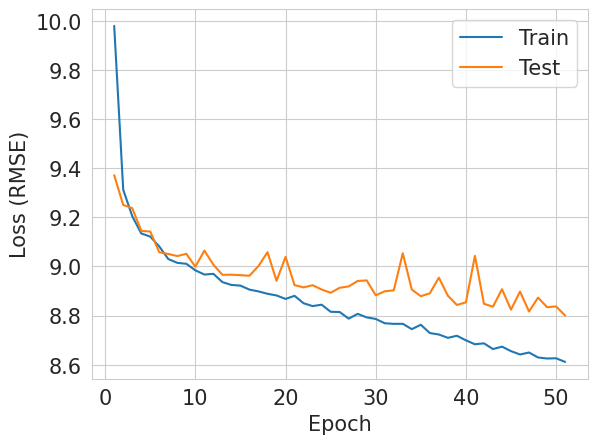

Train loss: 8.61
Test loss: 8.80
Min test loss: 8.8000
Training finished


In [ ]:
set_random_seed(42)

train(model, optimizer, criterion, train_loader, test_loader)

## Задание 3. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

**Для получения достигнутых результатов работы модели был использован ряд средств и значений гиперпараметров:**

1) ***StandardScaler*** для масштабирования признаков и нормировки таргета (благодаря этому модель на обучении гораздо лучше сходилась, судя по всему в связи с тем, что объекты совершенно не сбалансированны, что можно увидеть на гистограмме ниже),

2) Оптимизатор ***AdamW***, так как он в себе объединяет идеи сразу нескольких оптимизаторов и в отличие от того же ***SGD*** практически не нуждается в дополнительной настройке гиперпараметров (e.g. в данной модели использование того же ***Scheduler*** для ***AdamW*** не улучшало ее показателей). Начальный размер шага для оптимизатора был выбран 1e-4, чтобы обеспечить лучшую сходимость модели,

3) ***MSELoss*** для проверки качества модели, так как мы хотим добиться лучшего результата по RMSE (зависит от MSE),

4) 1024 объекта в одном батче на обучении является относительным стандартом для большой обучающей выборки (больше 400.000 объектов),

5) 3 скрытых слоя в модели были выбраны эмпирически, ввиду возникновения переобучения при большем числе слоев и недостаточной сложности модели для качественного обучения,

6) 640 нейронов в скрытых слоях были выбраны эмпирически для покрытия большинства возможных закономерностей в обучающих объектах,

7) Функция-активатор ***ReLU***, так как решается задача регрессии,

8) ***Dropout*** (с вероятностью 0.25) выключен, хотя изначально тестировались варианты с включенным дропаутом между линейными слоями для предотвращения потенциального переобучения,

9) 150 эпох для обучения, чтобы модель точно успела обучиться по данным настройкам (оказалось достаточно 50).

Благодаря таким настройкам мне удалось добиться следующего лучшего качества модели на тестовой выборке: **<8.8 (RMSE)**.

In [ ]:
# Эксперимент 1: 2 скрытых слоя, MinMaxScaler для таргета, Оптимизатор AdamW, Dropout, 2048 нейронов, 150 эпох, 1024 размер батча. Результат: 8.82 (неплохо, но можно лучше)
# (Оно обучалось на GPU почти 3 часа, поэтому я не буду это перезапускать, хорошо, что скрин остался, только с неотнормированным таргетом для графика на трейне, но это не влияет на результат)

# Нормируем признаки
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

# Подготавливаем скейлер для таргета
target_scaler = StandardScaler()
target_scaler.fit(y_train.reshape(-1, 1))
y_train_norm = target_scaler.transform(y_train.reshape(-1, 1))

INPUTS = 90
OUTPUTS = 1
HIDDEN_SIZE = 2048
EPOCHS = 150

set_random_seed(42)

train_set = MusicDataset(X_train_norm, y_train_norm)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=1024)

test_set = MusicDataset(X_test_norm, y_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=10000)

model = BebraNet(INPUTS, HIDDEN_SIZE, OUTPUTS).to(torch.double).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=25)
criterion = nn.MSELoss()

set_random_seed(42)

train(model, optimizer, criterion, train_loader, test_loader)

Это картинка, а не график

![result](https://github.com/L4sTH0qE/deep_learning_2024/raw/main/МинМакс2048нейронов.png)

Training:  98%|#########8| 49/50 [20:15<00:24, 24.31s/it]

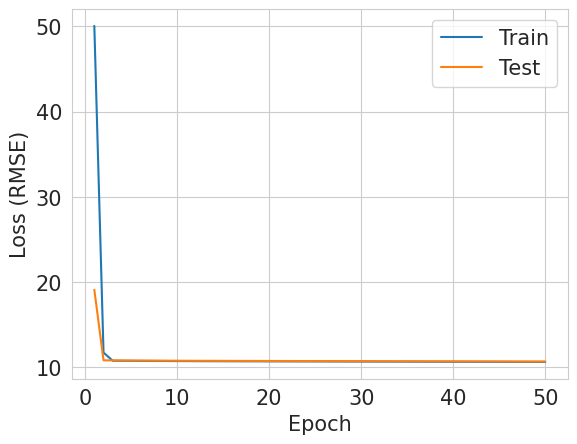

Train loss: 10.59
Test loss: 10.64
Min test loss: 10.6430
Training finished


In [ ]:
# Эксперимент 2: 2 скрытых слоя, MinMaxScaler для таргета, Оптимизатор SGD, без Dropout, 1024 нейрона, 50 эпох, 1024 размер батча. Результат: 10.64 (очень плохой показатель)

# Нормируем признаки
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

# Подготавливаем скейлер для таргета
target_scaler = MinMaxScaler()
target_scaler.fit(y_train.reshape(-1, 1))
y_train_norm = target_scaler.transform(y_train.reshape(-1, 1))

INPUTS = 90
OUTPUTS = 1
HIDDEN_SIZE = 1024
EPOCHS = 50

set_random_seed(42)

train_set = MusicDataset(X_train_norm, y_train_norm)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=1024)

test_set = MusicDataset(X_test_norm, y_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=10000)

model = BebraNet(INPUTS, HIDDEN_SIZE, OUTPUTS).to(torch.double).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=25)
criterion = nn.MSELoss()

set_random_seed(42)

train(model, optimizer, criterion, train_loader, test_loader)

Training:  99%|#########9| 99/100 [24:59<00:15, 15.02s/it]

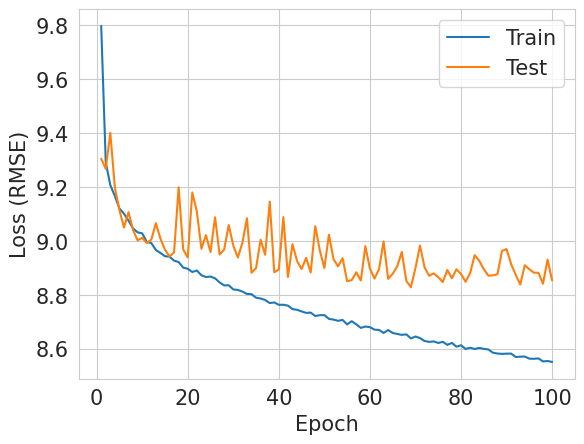

Train loss: 8.55
Test loss: 8.85
Min test loss: 8.8274
Training finished


In [ ]:
# Эксперимент 3: 3 скрытых слоя, StandardScaler для таргета, Оптимизатор AdamW, без Dropout-а, 256 нейронов, 100 эпох, 256 размер батча. Результат: 8.82 (отлично, не хватает небольшого улучшения)

# Нормируем признаки
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

# Подготавливаем скейлер для таргета
target_scaler = StandardScaler()
target_scaler.fit(y_train.reshape(-1, 1))
y_train_norm = target_scaler.transform(y_train.reshape(-1, 1))

INPUTS = 90
OUTPUTS = 1
HIDDEN_SIZE = 256
EPOCHS = 100

set_random_seed(42)

train_set = MusicDataset(X_train_norm, y_train_norm)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=256, shuffle=True)

test_set = MusicDataset(X_test_norm, y_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=10000)

model = BebraNet(INPUTS, HIDDEN_SIZE, OUTPUTS).to(torch.double).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=25)
criterion = nn.MSELoss()

set_random_seed(42)

train(model, optimizer, criterion, train_loader, test_loader)


## Задание 4. (10 баллов)

А теперь давайте попробуем решить задачу классификации на тех же данных!

Протестируйте два варианта:

1. Cчитайте каждый год, представленный в таблице, за отдельный класс

2. Разбейте года на 10 бинов и решайте задачу классификации для 10 классов

Добавьте в test подсчет метрик: accuracy, precision, recall (можете выбрать micro или macro усреднение, как посчитаете нужным).

Что можно сказать о полученных моделях? Почему результаты вышли такими? Напишите небольшой анализ того, что было проделано, чем модели классификации отличаются от задачи регрессии и друг друга?

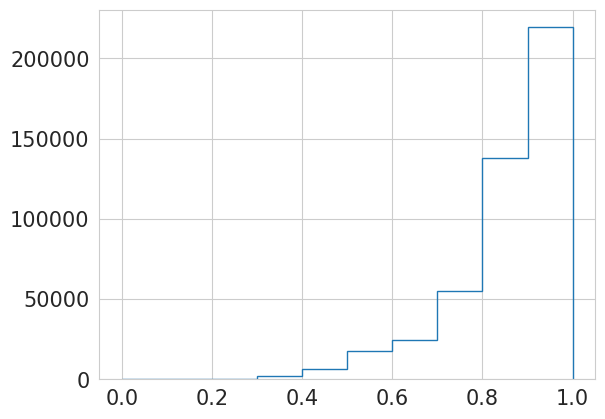

In [ ]:
INPUTS = 90
FIRST_NUM_CLASSES = len(np.unique(y_train))
SECOND_NUM_CLASSES = 10
HIDDEN_SIZE = 1024
EPOCHS = 50

set_random_seed(42)

# Подготавливаем таргет для классификации 1 (сделаем втупую, с помощью индексов в массиве уникальных значений из y_train)
value_to_index = {val: id for id, val in enumerate(np.unique(y_train))}
y_first_class_train = np.array([value_to_index[val] for val in y_train])
y_first_class_test = np.array([value_to_index[val] for val in y_test])

# Подготавливаем таргет для классификации 2
target_scaler = MinMaxScaler()
y_train_norm = target_scaler.fit_transform(y_train.reshape(-1, 1)).squeeze()
y_test_norm = target_scaler.transform(y_test.reshape(-1, 1)).squeeze()

y_second_class_train = pd.cut(y_train_norm, bins=[-np.inf,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,np.inf], labels=[0,1,2,3,4,5,6,7,8,9]).to_numpy()
y_second_class_test = pd.cut(y_test_norm, bins=[-np.inf,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,np.inf], labels=[0,1,2,3,4,5,6,7,8,9]).to_numpy()

# Построим-ка график распределения классов (я обалдел, когда увидел).
counts, bins = np.histogram(y_train_norm)
plt.stairs(counts, bins)

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score # Возьмем готовые метрики с микроусреднением, чтобы не страдать хотя бы в этом задании.

def train_classification(model, optimizer, criterion, train_loader, test_loader, scheduler=None):
    """
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        test_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
    """
    # Список для хранения значений потерь (нужны для построения графиков).
    train_losses, test_losses = [], []

    progress_bar = tqdm(range(1, EPOCHS + 1), desc='Training')

    # Цикл эпох обучения.
    for epoch in progress_bar:
        train_loss = 0.0

        model.train()
        for X, y in train_loader:
            X = X.to(device)
            y = y.to(device)

            optimizer.zero_grad()
            logits = model(X)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X.shape[0]

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)
        # Применяем scheduler, если юзаем его.
        if scheduler is not None:
            scheduler.step(train_loss)

        test_loss = 0.0
        model.eval()
        for X, y in test_loader:
            X = X.to(device)
            y = y.to(device)

            with torch.no_grad():
                logits = model(X)
                loss = criterion(logits, y)
            test_loss += loss.item() * X.shape[0]

        test_loss /= len(test_loader.dataset)
        test_losses.append(test_loss)

        clear_output()
        display(progress_bar.container)
        plot_losses(train_losses, test_losses)
        print("Train loss:", "{:.2f}".format(train_losses[-1]))
        print("Test loss:", "{:.2f}".format(test_losses[-1]))
        print("Min test loss:", "{:.4f}".format(np.min(test_losses)))
    print("Training finished")

def test_classification(model, criterion, test_loader):
    """
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        test_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    """

    model.eval()
    predicts = []
    true_values = []
    for X, y in test_loader:
        X = X.to(device)

        with torch.no_grad():
            logits = model(X).argmax(dim=1)
            y_true = y.numpy()
            predicts.append(logits)
            true_values = np.append(true_values, y_true)
    true_values = np.array(true_values, dtype=int)
    predicts = torch.cat(predicts, dim=0)
    predicted_values = predicts.detach().cpu().numpy().astype(np.int64) # tensor to ndarray
    accuracy = accuracy_score(true_values, predicted_values)
    precision = precision_score(true_values, predicted_values, average='macro', zero_division=0)
    recall = recall_score(true_values, predicted_values, average='macro', zero_division=0)
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    return predicts

In [ ]:
# Вариант 1
set_random_seed(42)

train_set = MusicDataset(X_train_norm, y_first_class_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=1024)

test_set = MusicDataset(X_test_norm, y_first_class_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=10000)

model = BebraNet(INPUTS, HIDDEN_SIZE, FIRST_NUM_CLASSES).to(torch.double).to(device) # Модель запускалась с дропаутом и 2 скрытыми слоями.
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

Training:  98%|#########8| 49/50 [20:47<00:25, 25.01s/it]

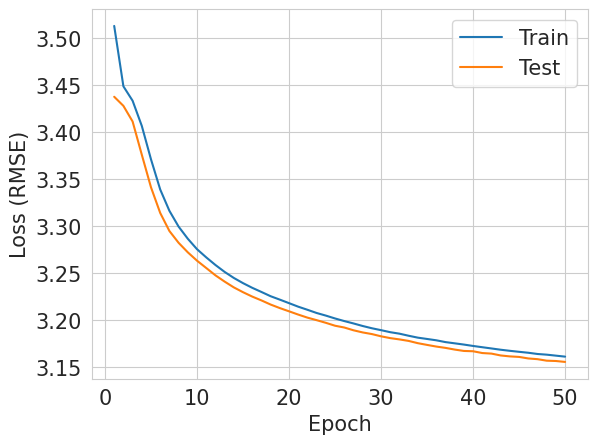

Train loss: 3.16
Test loss: 3.16
Min test loss: 3.1557
Training finished


In [ ]:
set_random_seed(42)

train_classification(model, optimizer, criterion, train_loader, test_loader)

In [ ]:
assert test_classification(model, criterion, test_loader).shape[0] == y_first_class_test.shape[0]

Accuracy: 0.0858
Precision: 0.0464
Recall: 0.0245


In [ ]:
# Вариант 2
set_random_seed(42)

train_set = MusicDataset(X_train_norm, y_second_class_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=1024)

test_set = MusicDataset(X_test_norm, y_second_class_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=10000)

model = BebraNet(INPUTS, HIDDEN_SIZE, SECOND_NUM_CLASSES).to(torch.double).to(device) # Модель запускалась с дропаутом и 2 скрытыми слоями.
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

Training:  98%|#########8| 49/50 [19:49<00:23, 23.55s/it]

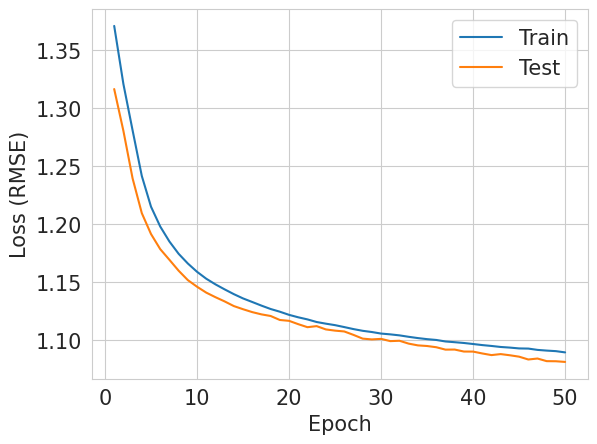

Train loss: 1.09
Test loss: 1.08
Min test loss: 1.0810
Training finished


In [ ]:
set_random_seed(42)

train_classification(model, optimizer, criterion, train_loader, test_loader)

In [ ]:
assert test_classification(model, criterion, test_loader).shape[0] == y_test.shape[0]

Accuracy: 0.5507
Precision: 0.2361
Recall: 0.1600


Для решения задачи классификации (обоих вариантов) в построенной модели был измененен размер выходного слоя нейросети и также было уменьшено число эпох для более быстрого обучения. Конечно, метрики имели бы более хорошее качество, если бы модели обучались большее количество эпох, однако результаты уже на 50-ой эпохе позволяют сделать определенные выводы.

Полученные модели получились довольно плохими ввиду несбалансировонности объектов в обучающей выборке (по сути большинство объектов относится к классам соответствующим годам с 2000 по 2011).

В первом варианте модели классификации нейросеть игнорирует около половины маленьких классов (классов, к которым относится маленькое число объектов из выборки) из-за чего резко падают показатели метрик. Все три показателя (Доля правильных ответов, точность и полнота) непозволительно низки - **< 0.1**. Важно отметить, что для оценки качества моделей метрики считались с макроусреднением, поэтому они отражают честное качество модели по отношению ко всем классам независимо от их размера.

Во втором варианте ситуация куда лучше, но все еще прослеживается тенденция на игнорирование маленьких классов (об этом свидетельствует низкая полнота (**0.16**) и низкая точность (**0.23**)). Относительно высокая доля правильных ответов (**0.55**) во втором варианте не отражает высокое качество модели, так как в ней большинство объектов на обучающей и тестовой выборка относятся к 9-му и 10-му классам, представителей которых в этих выборках больше всего.

Показатели метрик в целом во втором варианте гораздо лучше, чем в первом, так как модели не нужно замечать небольшие отличия между соседними классами, что довольно трудно сделать простой модели, коей и является построенная нейросеть. Можно с уверенностью сказать, что построенная нейросеть гораздо лучше справляется с задачей регрессии, потому что целевая переменная, которую мы пытаемся предсказать - дата выхода песни является плавной величиной (тенденции на стиль песен меняются плавно от года к году из-за чего проще выделить временную эпоху, чем конкретные года написания).